In [2]:
import torch
import torch.nn as nn
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib



In [3]:
device = 'cuda'

In [16]:
#Distillation loss for AE

class dist_loss():
    def __init__(self):
        self.student_loss = nn.MSELoss()
        self.distillation_loss = nn.MSELoss()
        self.temperature = 1
        self.alpha = 0.25

    def __call__(self, student_logits, student_target_loss, teacher_logits):
        distillation_loss = self.distillation_loss((student_logits / self.temperature),
                                                   (teacher_logits / self.temperature))

        loss = (1 - self.alpha) * student_target_loss + self.alpha * distillation_loss
        return loss
    

# Traditional Knowledge distillation

This is a traditional attempt at knowledge distillation taking a larger AE trained on mips to a smaller AE.

NOTE: This is mean nonzero, std 1 and mips!

In [66]:
%ls models

2023-03-21_04-21_model_trainings/
2023-03-21_04-23-57_model_trainings/
2023-03-21_15-27-08_model_trainings/
2023-03-21_19-41-12_model_trainings/
2023-03-22_04-38-55_model_trainings/
2023-03-22_04-39-30_model_trainings/
2023-03-22_04-40-34_model_trainings/
2023-03-22_04-40-45_model_trainings/
2023-03-29_20-46-35_model_trainings/
batch_4_models_tt_bar_norm_mean_0_var_1_model_trainings/
batched_models/
cur_dir/
dt_1_greater_0_250_100
dt_1_greater_0_250_100_dif
dt_1_greater_0_250_100_log
dt_1_greater_0_450_250_100_dif
dt_1_greater_0_450_250_100_dif_2
dt_1_greater_0_450_250_100_dif_high_alpha
dt_1_greater_0_450_250_100_dif_low_alpha
dt_1_greater_0_450_250_100_log_2
dt_1_greater_0_800_250_100_dif
dt_1_greater_0_avg
dt_1_greater_0_low
dt_1_greater_0_low_1
dt_1_greater_0_low_2
dt_1_greater_0_low_3
dt_1_greater_0_m1
dt_1_greater_0_m2
dt_1_greater_0_mid_1
dt_1_greater_0_mid_2
dt_1_greater_0_mid_3
dt_1_outlier_greater_0
dt_1_outlier_greater_0_1
dt_1_student
dt_2_greater_0_250_100
dt_2_greater_0_2

In [11]:
#Load Teacher
teacher = torch.load('models/MIP_150_50_greater_1')
teacher

Naive_DAE(
  (encoders): ModuleList(
    (0): Linear(in_features=48, out_features=150, bias=True)
    (1): ReLU()
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoders): ModuleList(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=150, bias=True)
    (4): ReLU()
    (5): Linear(in_features=150, out_features=48, bias=True)
    (6): ReLU()
  )
)

In [9]:
#Load Student
student = Naive_DAE([48,50,16])
student

Naive_DAE(
  (encoders): ModuleList(
    (0): Linear(in_features=48, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=16, bias=True)
    (3): ReLU()
  )
  (decoders): ModuleList(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=48, bias=True)
    (4): ReLU()
  )
)

### Load in MIP data

In [6]:
n = 20

arr = torch.load('MIT_TTbar/ntuple_1_greater_1_sim')

if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'MIT_TTbar/ntuple_{int(n+2)}_greater_1_sim')])

print(f'There are {len(arr)} wafers with sim energy > 1 ')
print(f'mean MIP is: {torch.mean(arr[:,0:48])}')
print(f'max MIP is: {torch.max(arr[:,0:48])}')

There are 525798 wafers with sim energy > 1 
mean MIP is: 0.9930326262415542
max MIP is: 1042.741943359375


### Normalizing data for training

In [7]:
dt_1 = arr.float()
print(f'{len(dt_1)} wafers of type 0')
print(f'mean MIP: {torch.mean(dt_1[:,0:48])}')
print(f'std MIP: {torch.std(dt_1[:,0:48])}')
mean_dt_1 = torch.mean(dt_1[:,0:48])
std_dt_1 = torch.std(dt_1[:,0:48])
dt_1[:,0:48] = (dt_1[:,0:48])/torch.std(dt_1[:,0:48])
dt_1 = dt_1.to(device)

525798 wafers of type 0
mean MIP: 0.9930304884910583
std MIP: 3.9623031616210938


### Datasets and Dataloaders

In [12]:
size_1_train =80000
size_1_test = 10000
train_loc = dt_1[0:size_1_train]
test_loc = dt_1[-size_1_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt_1[0:size_1_train,0:48]
test = dt_1[-size_1_test:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)

### Training

In [17]:
loss = dist_loss
lr = 0.00045
num_epochs = 100

In [ ]:

test = dt_1[-size_1_test:,0:48].to(device)

optimizer = optim.Adam(student.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
test = dt_1[-size_1_test:,0:48]

all_1_test_losses = []
all_1_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_1_d1_flat):
        student.train()
        data = data_list[0]
        
        
        s_pred = student(data)
        t_pred = teacher(data)
        
        # UPDATE FOR DISTILL
        # def __call__(self, student_logits, student_target_loss, teacher_logits):
        batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
        
        #Loss storage
        all_1_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        
        #Stepping Model
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    
    #Test Performance
    data_1_test = test
    model_1.eval()
    
    
    test_t_pred = teacher(data_1_test)
    test_s_pred = student(data_1_test)
    
    # UPDATE FOR DIST
    # def __call__(self, student_logits, student_target_loss, teacher_logits):

    batch_1_test = loss(data_1_test[:,0:48], test_pred,epoch,mean,std)
    
    
    all_1_test_losses.append(batch_1_test.item())
    running_loss = np.mean(losses)
    running_1est_loss = batch_1_test.item()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
student.eval()
AE_Stats.gen_all_stats(model_1(dt_1[-size_1_test:,0:48]).cpu(),dt_1[-size_1_test:,0:48].cpu(),dt_1[-size_1_test:].cpu())
torch.save(model_1,'models/MIP_450_250_150_greater_1')

# Piecewise Distillation Attempt

Here I try to take the perfect encoding from piecewise autoencoder and extend it to a larger autoencoder.

NOTE: These models were trained on mean 0 std 1 ttbar

Challenges: Purely computer science, because it is not a traditional problem, need to invent new methods.

In [3]:
m_low = torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1/low').to(device)
m_1 =torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1/m1').to(device)
m_2 = torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1/m2').to(device)
m_outlier = torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1/outlier').to(device)

In [4]:
def combined_model(ae_in):
    out = []
    for wafer in ae_in:
        if torch.norm(wafer) < 3:
            out.append(m_low(wafer))
        elif torch.norm(wafer)<5:
            out.append(m_1(wafer))
        elif torch.norm(wafer)< 10:
            out.append(m_2(wafer))
        else:
            out.append(m_outlier(wafer))
    return torch.vstack(out)

In [8]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [9]:
dt_1 = []


for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    
    
dt_1 = torch.vstack(dt_1).float()
print(f'{len(dt_1)} wafers of type 0')
print(f'mean calcq: {torch.mean(dt_1[:,0:48])}')
print(f'std calcq: {torch.std(dt_1[:,0:48])}')
mean_dt_1 = torch.mean(dt_1[:,0:48])
std_dt_1 = torch.std(dt_1[:,0:48])
dt_1[:,0:48] = (dt_1[:,0:48]-mean_dt_1)/torch.std(dt_1[:,0:48])
dt_1 = dt_1.to(device)

432654 wafers of type 0
mean calcq: 27.600881576538086
std calcq: 51.770050048828125


In [10]:
dt_outlier = []
dt_m1 = []
dt_m2 = []
dt_low = []

for d in dt_1:
    if torch.norm(d[0:48]).item() < 3:
        dt_low.append(d)
    elif torch.norm(d[0:48]).item() < 5:
        dt_m1.append(d)
    elif torch.norm(d[0:48]).item() < 10:
        dt_m2.append(d)
    else:
        dt_outlier.append(d)
        
dt_outlier = torch.vstack(dt_outlier)
dt_m1 = torch.vstack(dt_m1)
dt_m2 = torch.vstack(dt_m2)
dt_low = torch.vstack(dt_low)

In [33]:
total_test = []
total_train = []
for d in [dt_outlier,dt_m1,dt_m2,dt_low]:
    len_test = int(len(d)*0.15)
    total_test.append(d[-len_test:])
    total_train.append(d[0:int(len(d)*0.8)])
    


In [34]:
total_test = torch.vstack(total_test)[0:8000]
total_train = torch.vstack(total_train)[0:80000]

In [35]:
train_loc = total_train
test_loc = total_test
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = total_train[:,0:48]
test = total_test[:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)
#fine-tune autoencoder
#batch 500

In [25]:
import torch.nn.functional as F

/uscms_data/d3/nswood/mambaforge/envs/myenv/lib/python3.10/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 0, lr 4.5e-05
Epoch 0: Train 1.9759094093739986, Test 3.4976584911346436
Epoch 1, lr 4.5e-05
Epoch 1: Train 1.9753551264852285, Test 3.496504068374634
Epoch 2, lr 4.5e-05
Epoch 2: Train 1.9749083682149648, Test 3.495527744293213
Epoch 3, lr 4.5e-05
Epoch 3: Train 1.9746057626605034, Test 3.4948816299438477
Epoch 4, lr 4.5e-05
Epoch 4: Train 1.974421158209443, Test 3.4944725036621094
Epoch 5, lr 4.5e-05
Epoch 5: Train 1.9743080615997315, Test 3.4942119121551514
Epoch 6, lr 4.5e-05
Epoch 6: Train 1.9742373961955308, Test 3.4940452575683594
Epoch 7, lr 4.5e-05
Epoch 7: Train 1.9741923813521862, Test 3.493936777114868
Epoch 8, lr 4.5e-05
Epoch 8: Train 1.9741631750017405, Test 3.493865489959717
Epoch 9, lr 4.5e-05
Epoch 9: Train 1.9741439178586007, Test 3.4938182830810547
Epoch 10, lr 4.5e-05
Epoch 10: Train 1.9741310320049523, Test 3.493785858154297
Epoch 11, lr 4.5e-05
Epoch 11: Train 1.974122340232134, Test 3.4937644004821777
Epoch 12, lr 4.5e-05
Epoch 12: Train 1.9741163737326861

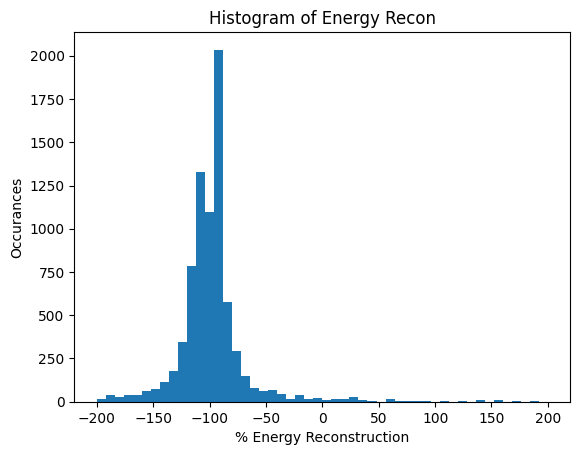

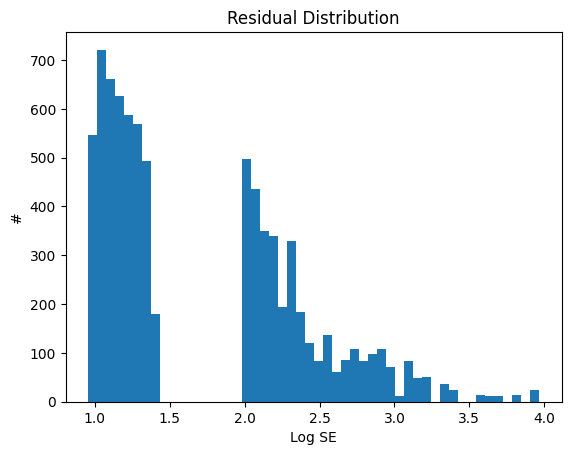

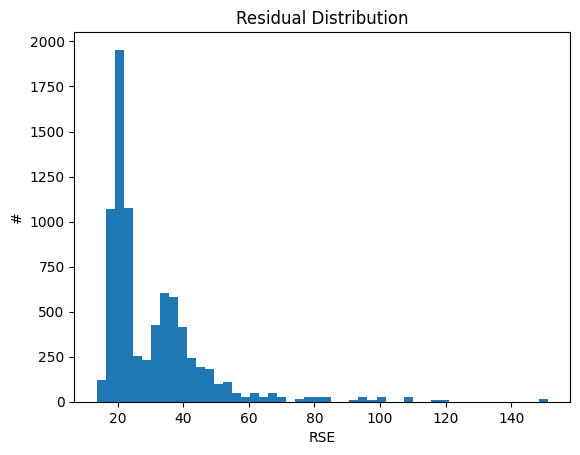

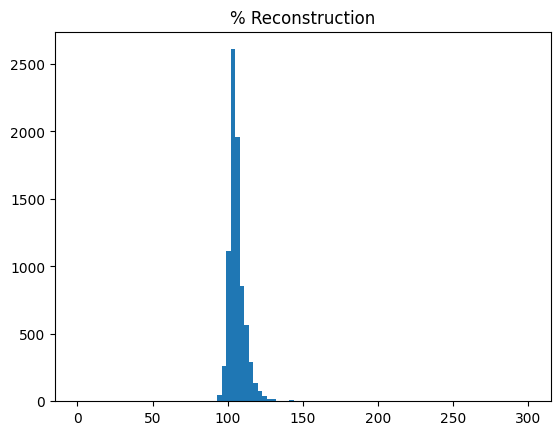

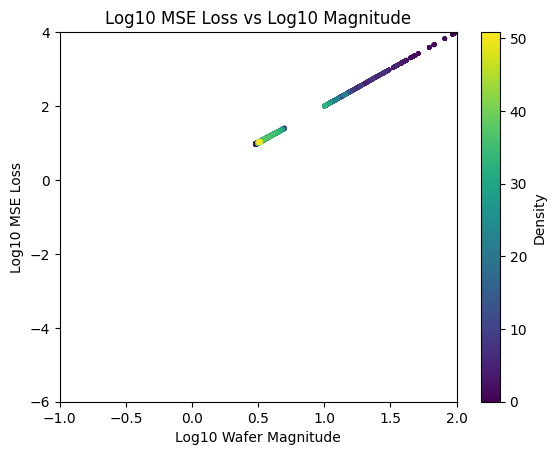

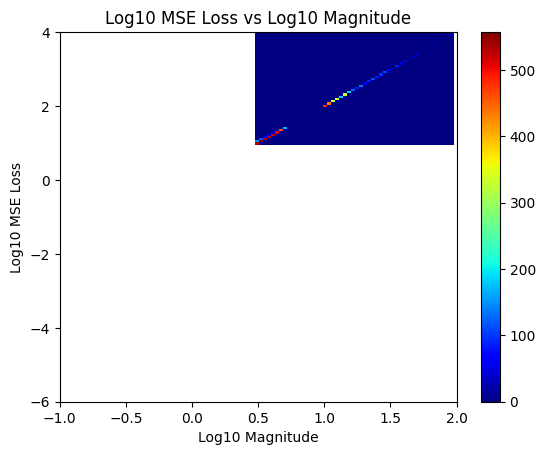

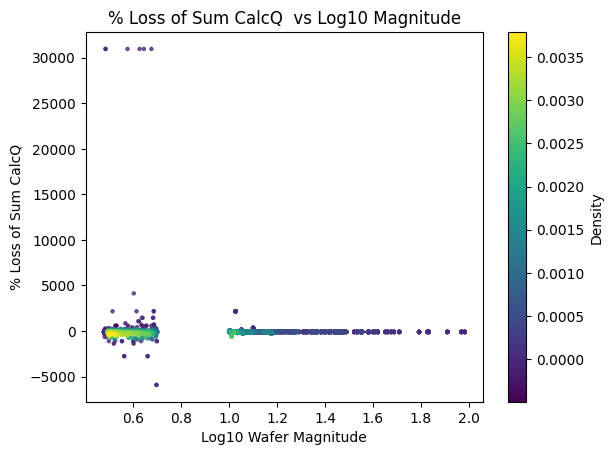

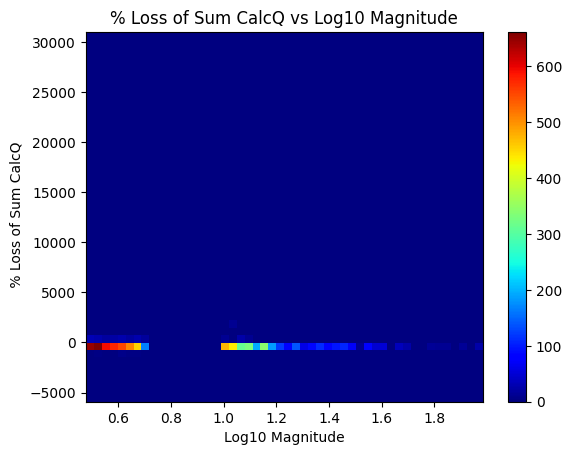

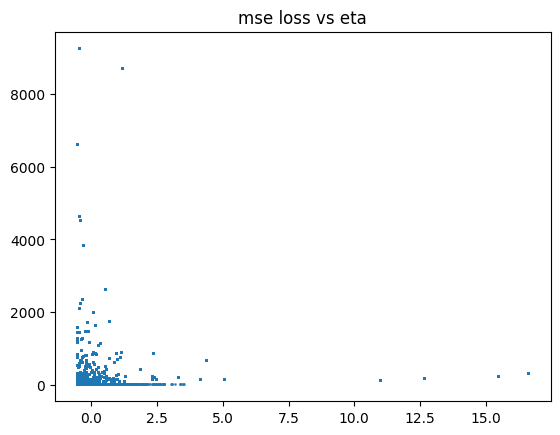

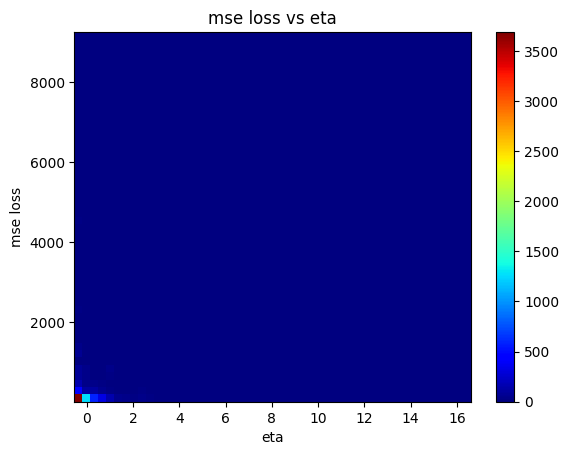

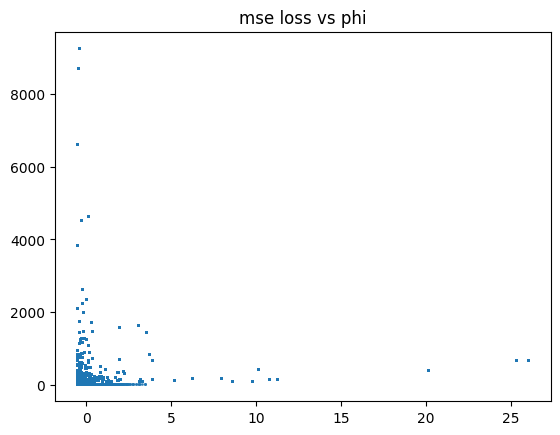

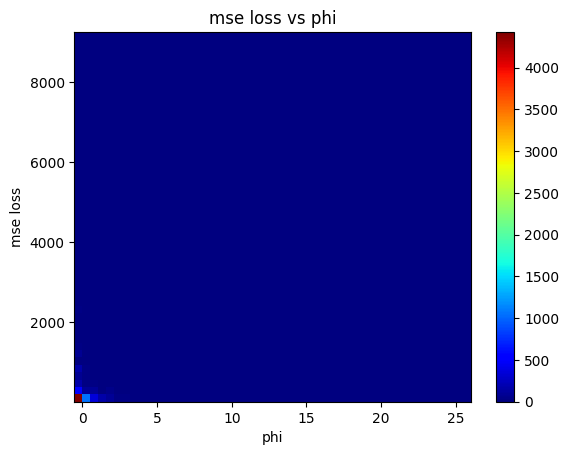

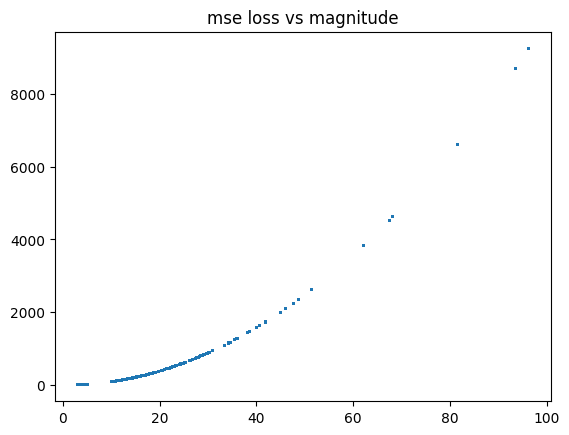

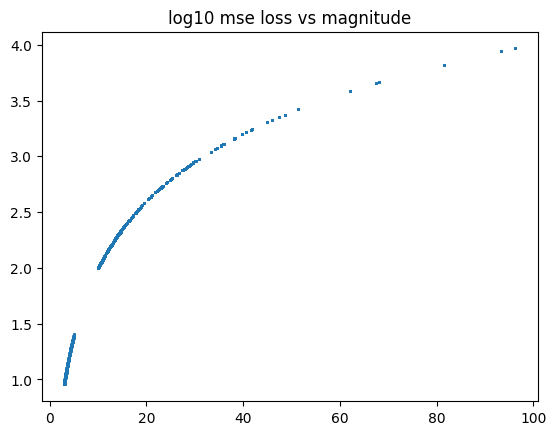

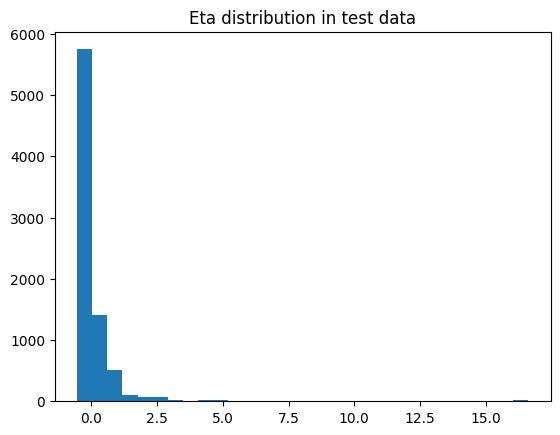

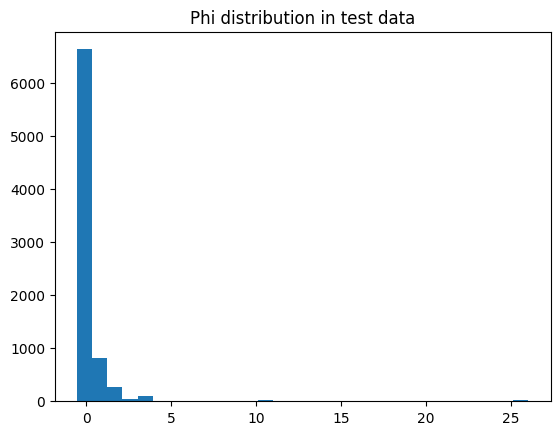

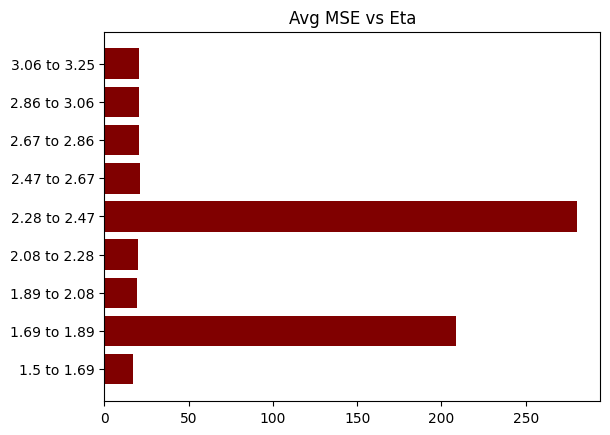

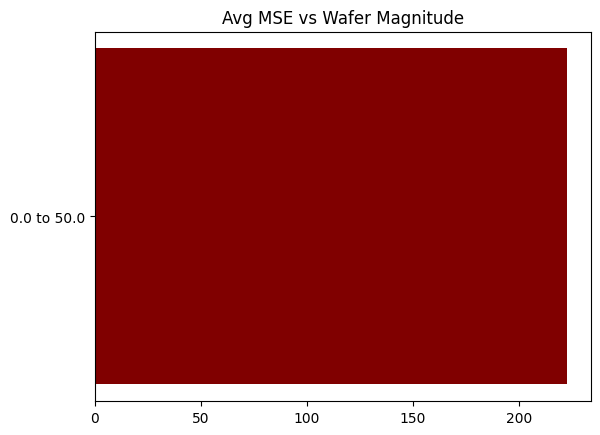

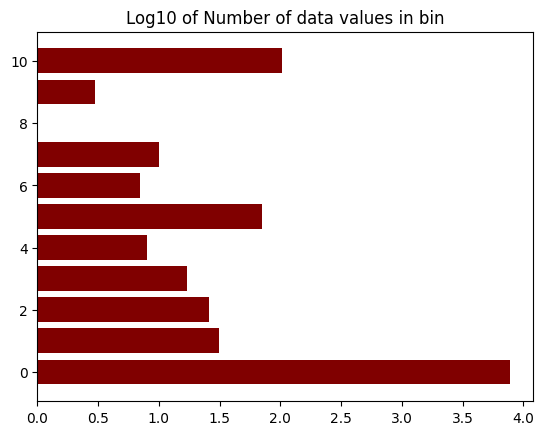

In [40]:
#fine-tune autoencoder
#batch 500

model_student= Naive_DAE([48,450,250,100,16]).to(device)
loss = DistillationLoss()

num_epochs = 100
lr = 0.000045
optimizer = optim.Adam(model_student.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)


all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_student.train()
        data = data_list[0]
        v_pred = model_student(data)
        teacher_pred = combined_model(data)
        data_loss = torch.nn.MSELoss()(v_pred, data).detach()
    
        batch_loss = loss(v_pred, data_loss, teacher_pred)
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    
    model_student.eval()
    test_pred = model_student(test)
    data_loss = torch.nn.MSELoss()(test_pred, test).detach()
    teacher_pred = combined_model(test)
    batch_test = loss(test_pred, data_loss, teacher_pred)
    all_test_losses.append(batch_test.item())
    running_loss = np.mean(losses)
    runningest_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {runningest_loss}")
model_student.eval()
AE_Stats.gen_all_stats(model_student(test[:,0:48]).cpu(),test[:,0:48].cpu(),test.cpu())
torch.save(model_student,'models/dt_1_student')

MSE 0.7530202865600586
Median 0.4971363842487335
Standard Devitaion 0.8996978402137756
Average std error 2.864471197128296
Average % Error of Energy Reconstruction 28.632728576660156


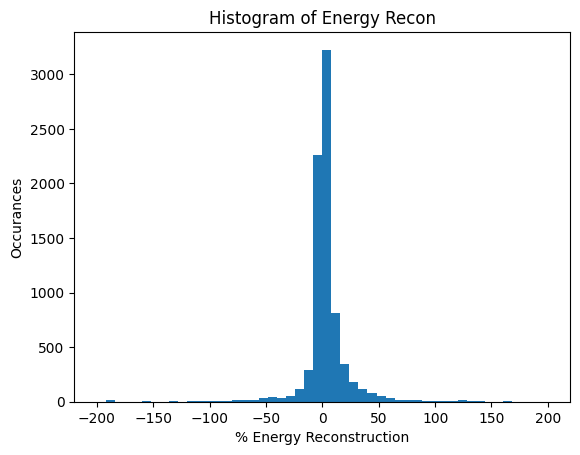

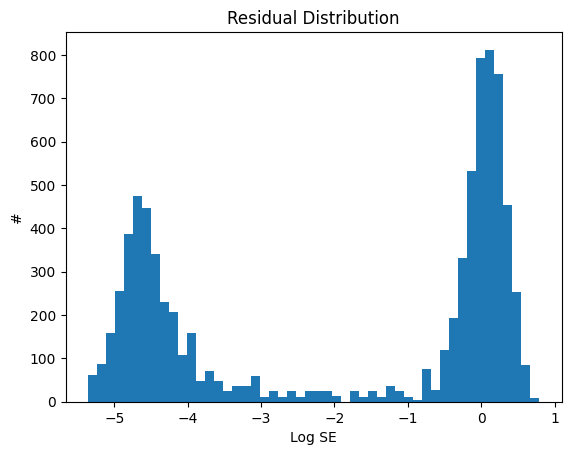

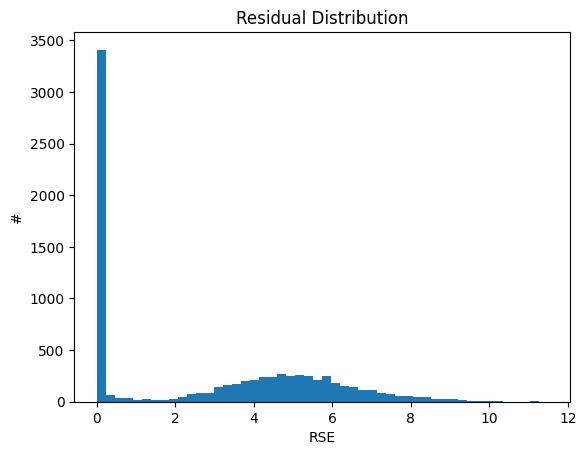

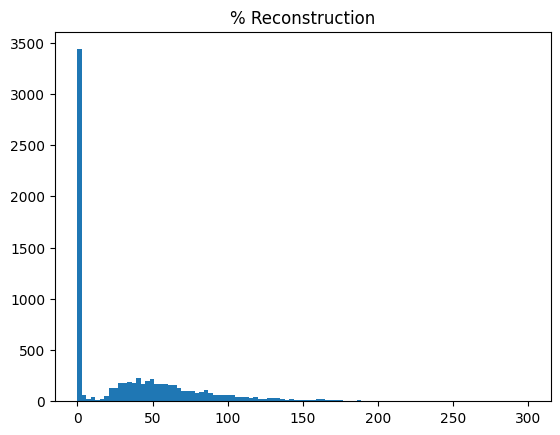

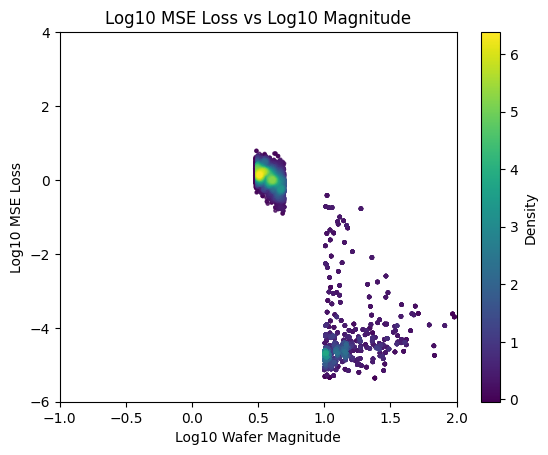

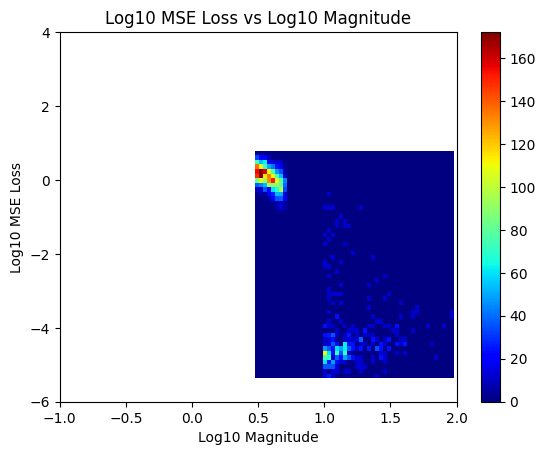

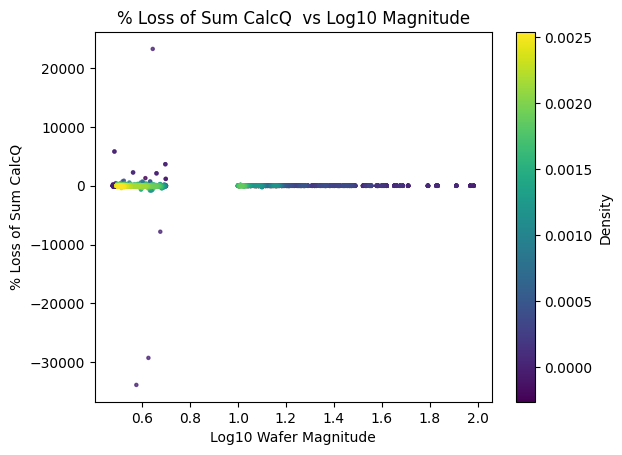

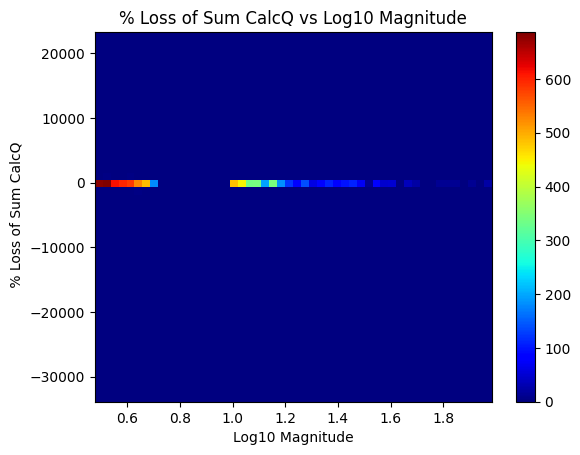

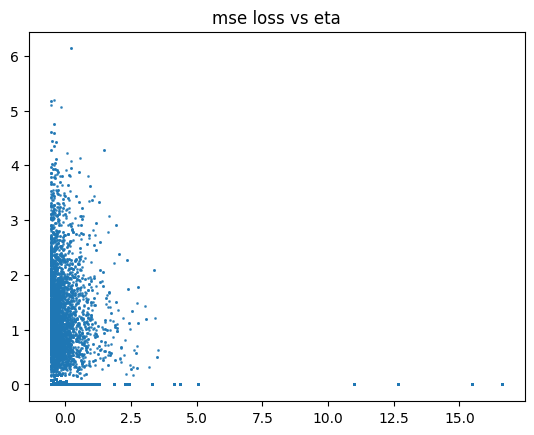

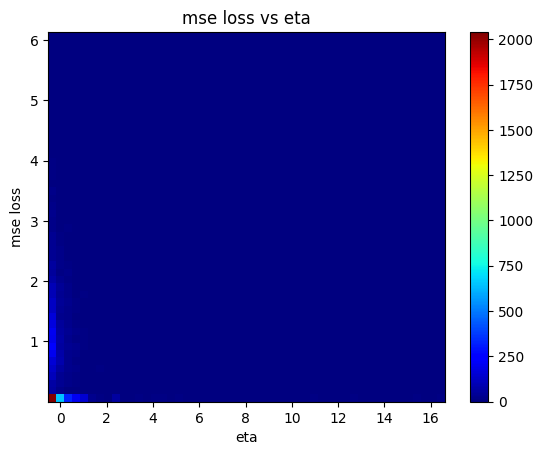

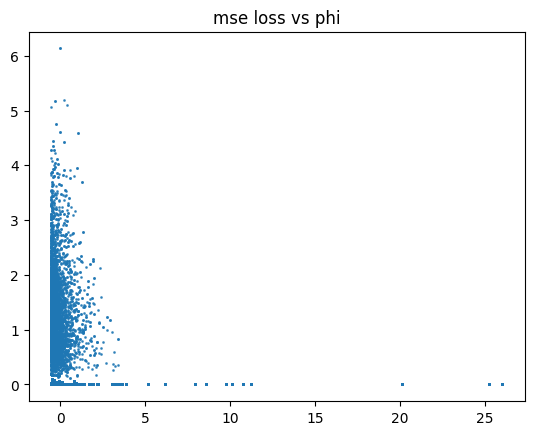

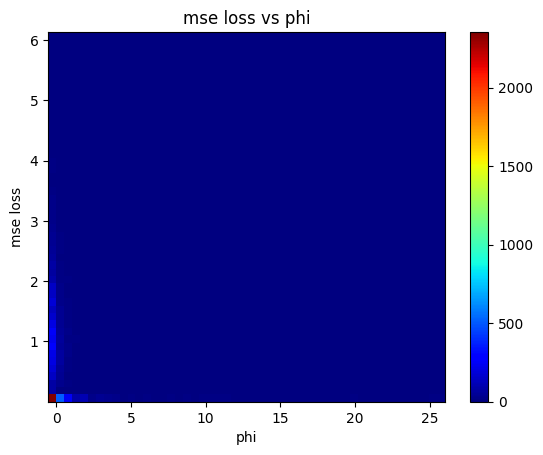

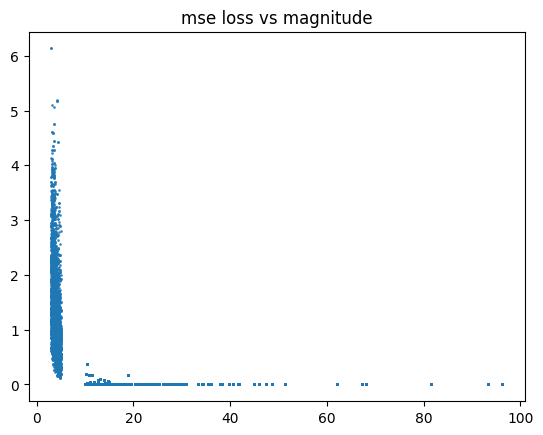

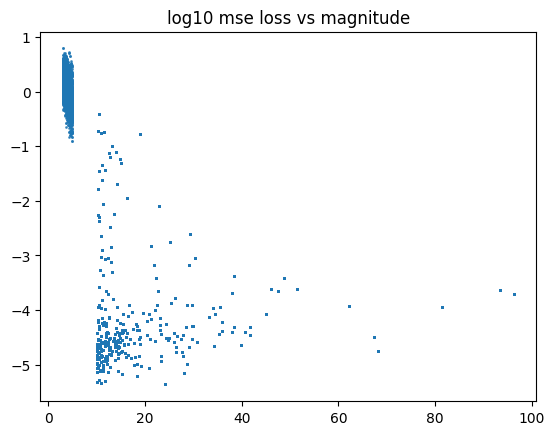

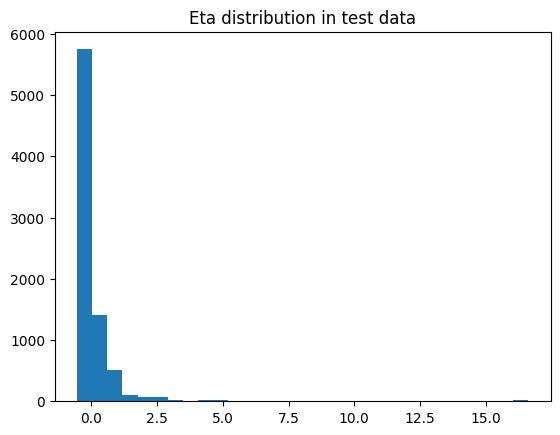

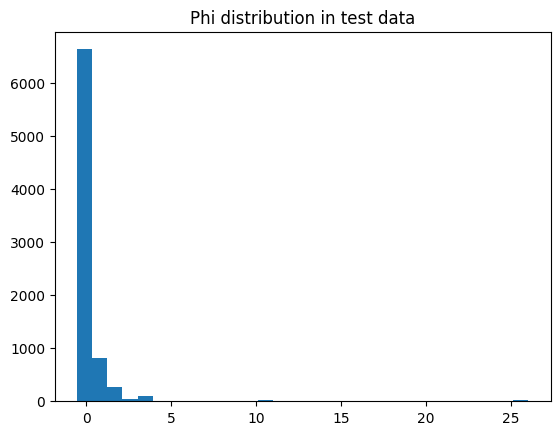

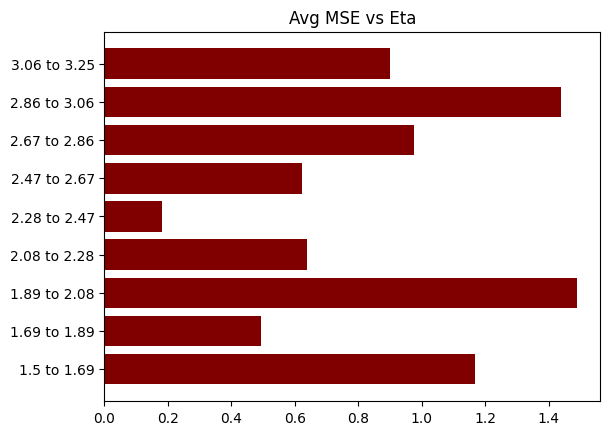

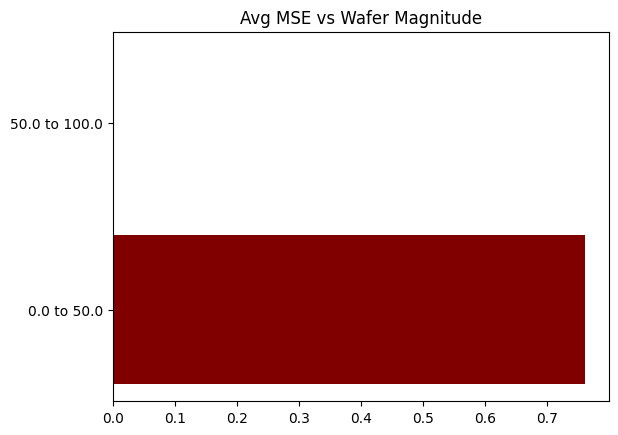

tensor([[-2.8203e-01, -1.2750e-01,  4.3545e+00,  5.9707e-01,  3.6235e+00],
        [-5.3314e-01,  8.3831e-01,  4.0224e+00,  1.9151e+00,  6.4481e+00],
        [-4.9451e-01, -3.3998e-01,  2.2081e+01,  2.7633e-05,  2.6089e-02],
        ...,
        [-3.9793e-01, -1.8545e-01,  1.4202e+01,  2.0527e-02,  2.3889e-01],
        [-5.3314e-01,  1.4757e+00,  4.3483e+00,  1.0082e+00,  4.8122e+00],
        [-4.3656e-01, -5.3314e-01,  4.3024e+00,  1.1298e+00,  4.8535e+00]],
       grad_fn=<CatBackward0>)

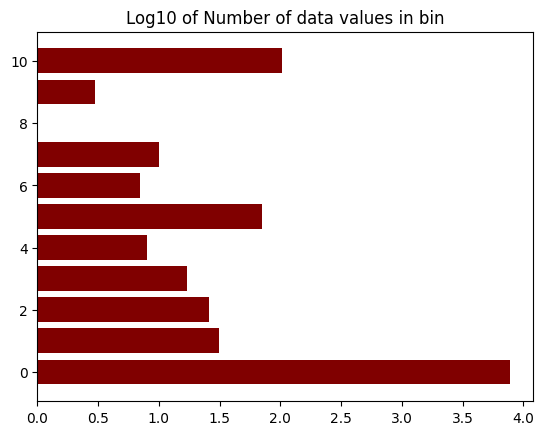

In [39]:
AE_Stats.gen_all_stats(combined_model(test[:,0:48]).cpu(),test[:,0:48].cpu(),test.cpu())


Epoch 0, lr 0.00045
Epoch 0: Train 1.9767040755599736, Test 3.499913454055786
Epoch 1, lr 0.00045
Epoch 1: Train 1.976340671479702, Test 3.4999160766601562
Epoch 2, lr 0.00045
Epoch 2: Train 1.976340709477663, Test 3.49991512298584
Epoch 3, lr 0.00045
Epoch 3: Train 1.9763406398892402, Test 3.499910593032837
Epoch 4, lr 0.00045
Epoch 4: Train 1.9763405218720436, Test 3.4999051094055176
Epoch 5, lr 0.00045
Epoch 5: Train 1.9763404466211796, Test 3.4999048709869385
Epoch 6, lr 0.00045
Epoch 6: Train 1.9763404473662376, Test 3.499906539916992
Epoch 7, lr 0.00045
Epoch 7: Train 1.976340497881174, Test 3.499907970428467
Epoch 8, lr 0.00045
Epoch 8: Train 1.9763405399769545, Test 3.499907970428467
Epoch 9, lr 0.00045
Epoch 9: Train 1.9763405515253545, Test 3.499908447265625
Epoch 10, lr 0.00045
Epoch 10: Train 1.9763405669480563, Test 3.499908447265625
Epoch 11, lr 0.000225
Epoch 11: Train 1.9763405746221543, Test 3.499908447265625
Epoch 12, lr 0.000225
Epoch 12: Train 1.9763405239582061, Te

Epoch 99, lr 8.7890625e-07
Epoch 99: Train 1.9763400683552026, Test 3.499904155731201
MSE 223.37173461914062
Median 22.406721115112305
Standard Devitaion 695.8690795898438
Average std error 30.314523696899414
Average % Error of Energy Reconstruction 100.0002670288086


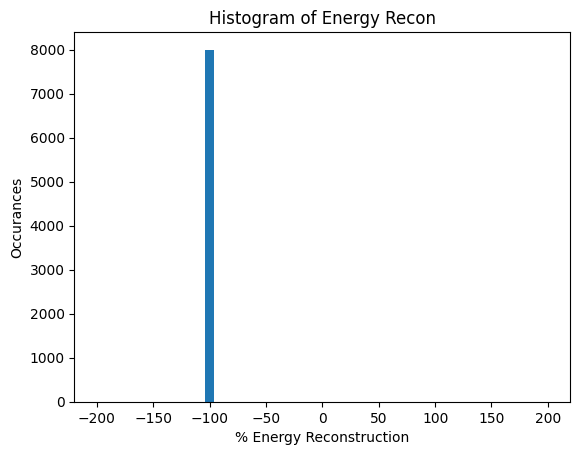

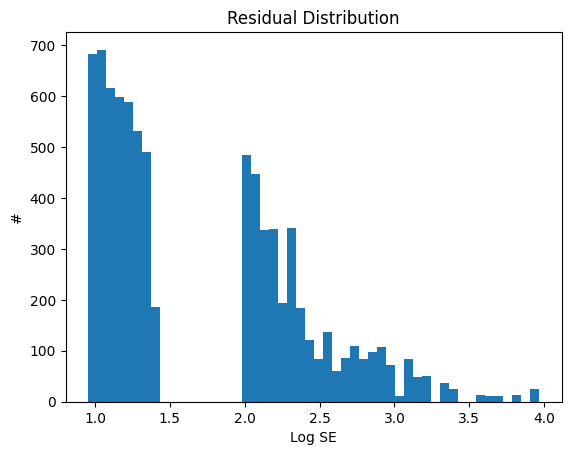

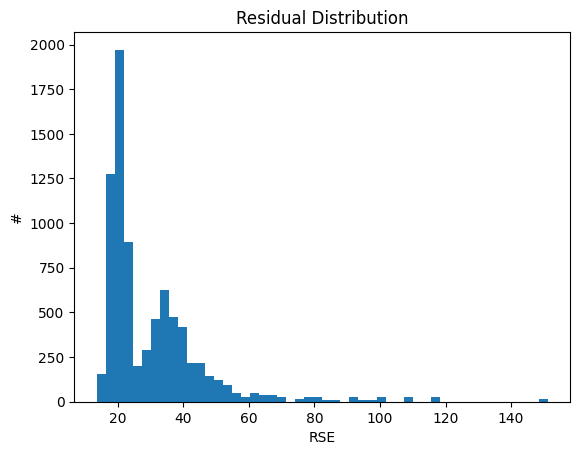

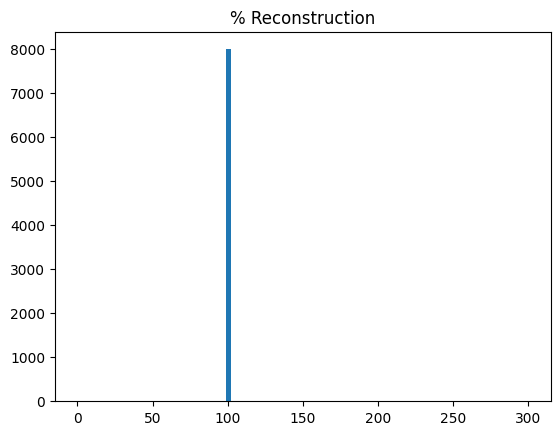

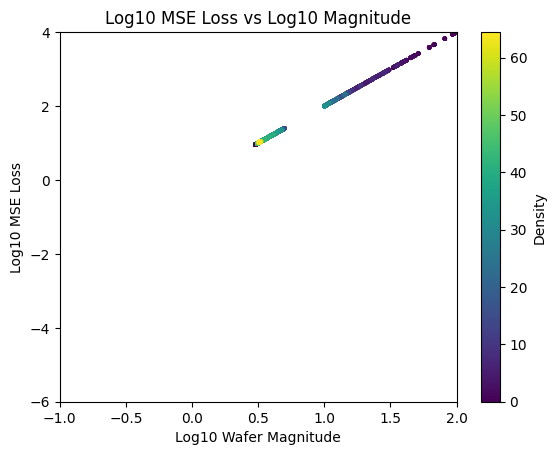

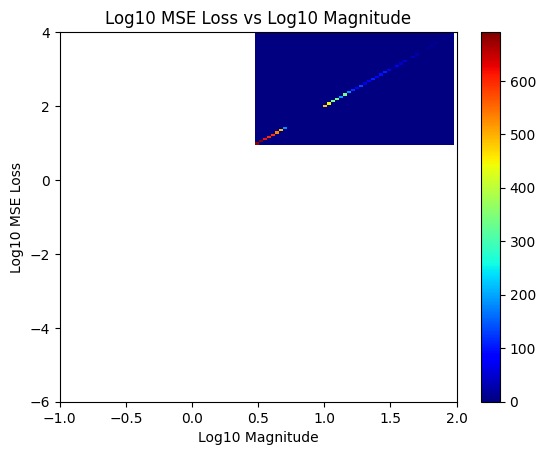

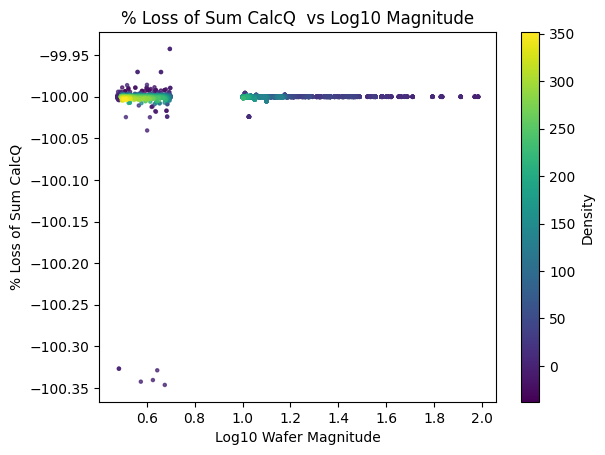

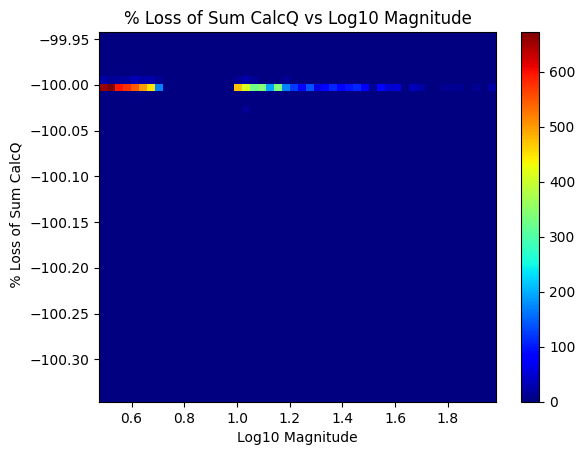

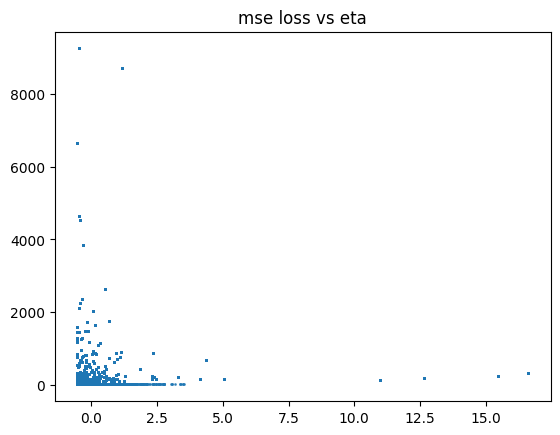

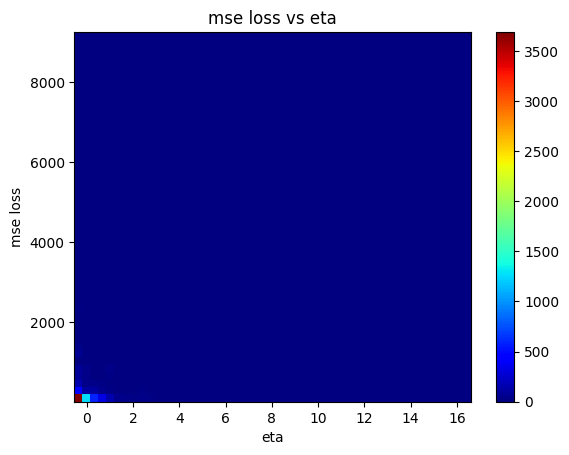

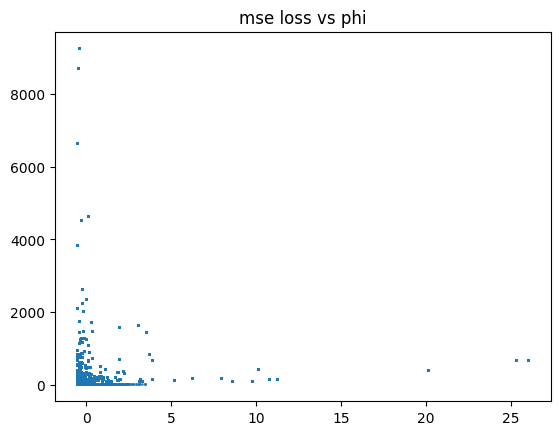

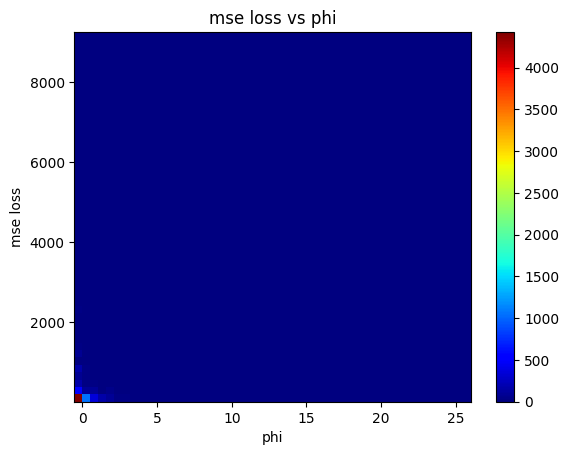

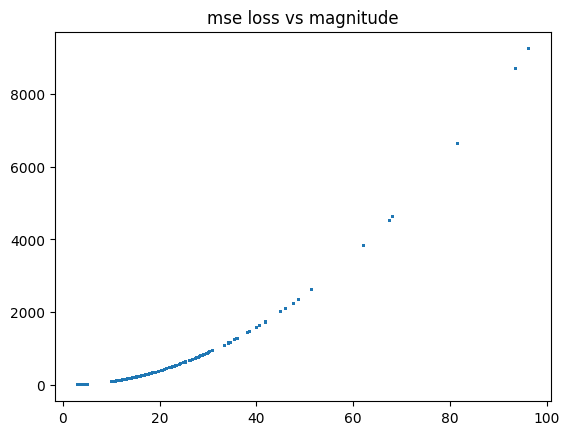

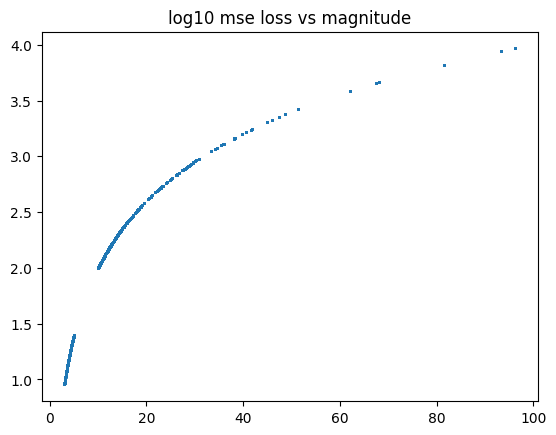

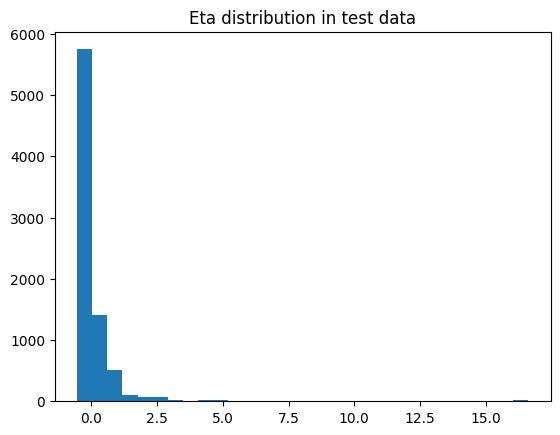

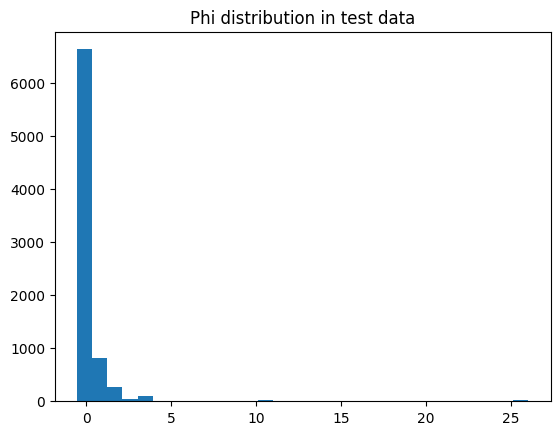

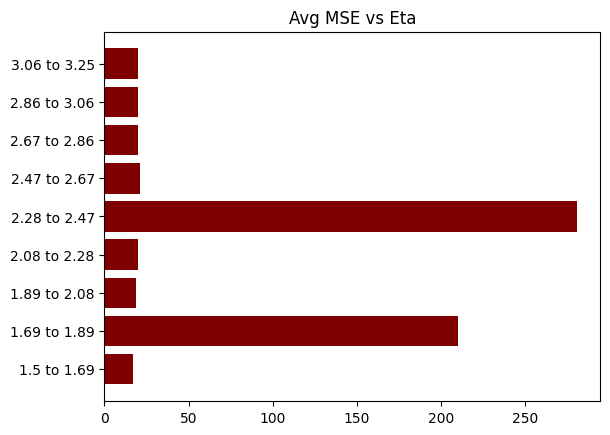

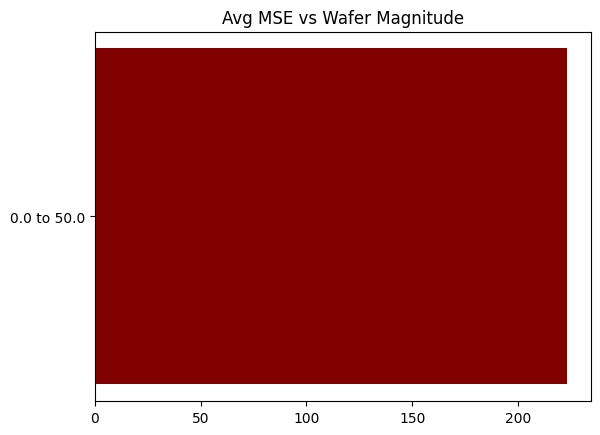

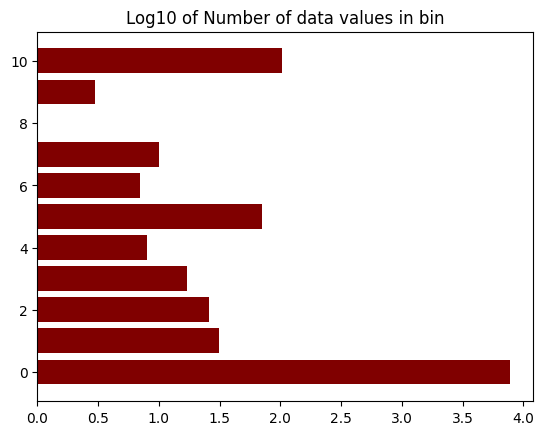

In [42]:
#fine-tune autoencoder
#batch 500
model_teacher =torch.load('models/dt_1_greater_0_450_250_100_dif_2').to(device) 
model_student= Naive_DAE([48,250,16]).to(device)
loss = DistillationLoss()

num_epochs = 100
lr = 0.00045
optimizer = optim.Adam(model_student.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)


all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_student.train()
        data = data_list[0]
        v_pred = model_student(data)
        teacher_pred = model_teacher(data)
        data_loss = torch.nn.MSELoss()(v_pred, data).detach()
    
        batch_loss = loss(v_pred, data_loss, teacher_pred)
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    
    model_student.eval()
    test_pred = model_student(test)
    data_loss = torch.nn.MSELoss()(test_pred, test).detach()
    teacher_pred = model_teacher(test)
    batch_test = loss(test_pred, data_loss, teacher_pred)
    all_test_losses.append(batch_test.item())
    running_loss = np.mean(losses)
    runningest_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {runningest_loss}")
model_student.eval()
AE_Stats.gen_all_stats(model_student(test[:,0:48]).cpu(),test[:,0:48].cpu(),test.cpu())
torch.save(model_student,'models/dt_1_student')